In [268]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')
np.random.seed(190)

In [302]:
#读取数据 
data=pd.read_csv('xgboost.csv') 
data=data.iloc[:,1:]
windows=3#时间窗长度
cut=100#最后预测的数量
lstm_size=16#lstm的神经元个数
epoch=60#训练次数
validation_split=0.1#验证集所占比例
batch_size=16
data.tail()

,post num,post per,cpi,isi,open,low,high,amount,money,close
1538,95152,47.332239,103.029298,66.971194,2834.9387,2802.4989,2834.9387,23518507600,2.440000e+11,2808.5293
1539,76622,34.619520,102.940217,65.976340,2812.2422,2802.9579,2832.6662,21013098100,2.250000e+11,2815.4947
1540,61146,27.584124,102.910716,65.623874,2819.9914,2758.2459,2821.7450,25387274500,2.710000e+11,2810.0243
1541,27162,12.826482,102.881311,65.260984,2801.3830,2800.7379,2831.7642,20206180700,2.230000e+11,2822.4424
1542,100028,54.142645,102.852003,64.887669,2832.3843,2832.3843,2865.5900,24245527800,2.770000e+11,2860.0822


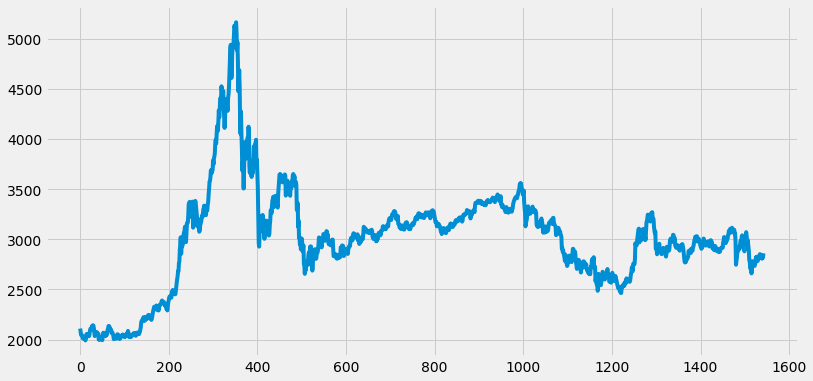

In [303]:
#展示一下看看
plt.figure(figsize=(12,6))
plt.plot(data['close'])

In [304]:
#区分特征和标签
y=data['close']
del data['close']
x=data
y=np.reshape(y.values, (-1,1))  

In [305]:
#归一化
from sklearn.preprocessing import MinMaxScaler
mm_x= MinMaxScaler()
mm_y= MinMaxScaler()
x= mm_x.fit_transform(x)
y= mm_y.fit_transform(y)

In [306]:
#构建lstm输入
df=pd.concat([pd.DataFrame(x),pd.DataFrame(y)],axis=1)
stock=df
seq_len=windows
amount_of_features = len(stock.columns)#有几列
data = stock.as_matrix() #pd.DataFrame(stock) 表格转化为矩阵
sequence_length = seq_len + 1#序列长度
result = []
for index in range(len(data) - sequence_length):#循环数据长度-sequence_length次
    result.append(data[index: index + sequence_length])#第i行到i+sequence_length
result = np.array(result)#得到样本，样本形式为6天*3特征
train = result[:-cut, :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[-cut:, :-1]
y_test = result[-cut:, -1][:,-1]
#reshape成 6天*3特征
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1439, 3, 10) (1439,) (100, 3, 10) (100,)


E:\anoconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [307]:
#建立LSTM模型 训练
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
#建立训练模型过程
model = Sequential()#建立层次模型
model.add(LSTM(lstm_size, input_shape=(windows, amount_of_features), return_sequences=False))#建立LSTM层
model.add(Dense(lstm_size,init='uniform',activation='relu'))   #建立全连接层     
model.add(Dense(1,init='uniform',activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 16)                1728      
_________________________________________________________________
dense_39 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 17        
Total params: 2,017
Trainable params: 2,017
Non-trainable params: 0
_________________________________________________________________


E:\anoconda\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  
E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':


In [308]:
#神经网络训练及结果
history= model.fit(X_train, y_train, nb_epoch =epoch, batch_size =batch_size,validation_split=validation_split) #训练模型nb_epoch次

E:\anoconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/60
1295/1295 [==============================] - 1s 1ms/step - loss: 0.0688 - accuracy: 7.7220e-04 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 2/60
1295/1295 [==============================] - 0s 153us/step - loss: 0.0048 - accuracy: 0.0015 - val_loss: 4.1945e-04 - val_accuracy: 0.0000e+00
Epoch 3/60
1295/1295 [==============================] - 0s 149us/step - loss: 0.0017 - accuracy: 0.0015 - val_loss: 8.6290e-04 - val_accuracy: 0.0000e+00
Epoch 4/60
1295/1295 [==============================] - 0s 154us/step - loss: 0.0011 - accuracy: 0.0015 - val_loss: 6.9033e-04 - val_accuracy: 0.0000e+00
Epoch 5/60
1295/1295 [==============================] - 0s 150us/step - loss: 7.4836e-04 - accuracy: 0.0015 - val_loss: 4.0272e-04 - val_accuracy: 0.0000e+00
Epoch 6/60
1295/1295 [==============================] - 0s 155us/step - loss: 6.5826e-04 - accuracy: 0.0015 - val_loss: 2.9714e-04 - val_accuracy: 0.0000e+00
Epoch 7/60
1295/1295 [=

1295/1295 [==============================] - 0s 270us/step - loss: 4.0819e-04 - accuracy: 0.0015 - val_loss: 1.2904e-04 - val_accuracy: 0.0000e+00
Epoch 53/60
1295/1295 [==============================] - 0s 274us/step - loss: 3.7322e-04 - accuracy: 0.0015 - val_loss: 1.4316e-04 - val_accuracy: 0.0000e+00
Epoch 54/60
1295/1295 [==============================] - 0s 289us/step - loss: 3.7562e-04 - accuracy: 0.0015 - val_loss: 2.1739e-04 - val_accuracy: 0.0000e+00
Epoch 55/60
1295/1295 [==============================] - 0s 281us/step - loss: 3.6527e-04 - accuracy: 0.0015 - val_loss: 1.2713e-04 - val_accuracy: 0.0000e+00
Epoch 56/60
1295/1295 [==============================] - 0s 298us/step - loss: 3.4801e-04 - accuracy: 0.0015 - val_loss: 2.2150e-04 - val_accuracy: 0.0000e+00
Epoch 57/60
1295/1295 [==============================] - 0s 279us/step - loss: 4.0230e-04 - accuracy: 0.0015 - val_loss: 1.2228e-04 - val_accuracy: 0.0000e+00
Epoch 58/60
1295/1295 [==============================] - 0

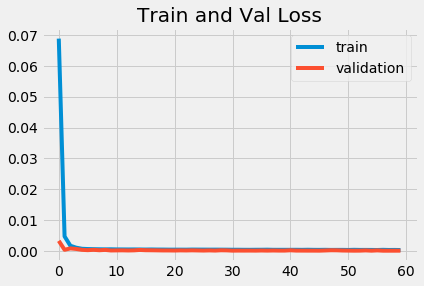

In [309]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Train Data')

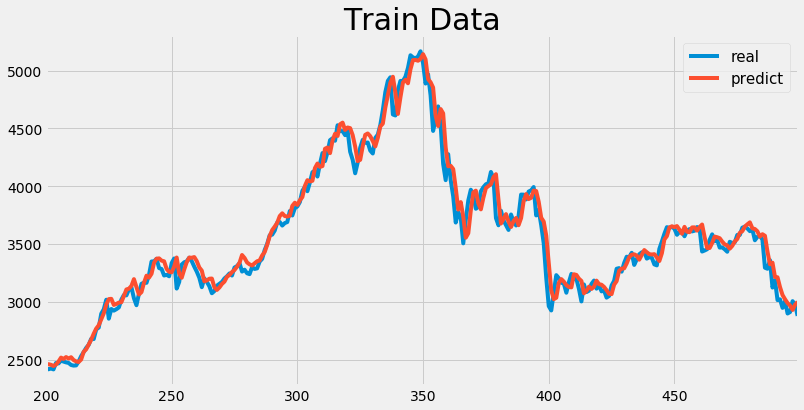

In [310]:
#在训练集上的拟合结果
y_train_predict=model.predict(X_train)
# 反归一化
y_train_predict=np.reshape(y_train_predict, (-1,1))  
y_train_predict= mm_y.inverse_transform(y_train_predict)
y_train=np.reshape(y_train, (-1,1))  
y_train=mm_y.inverse_transform(y_train)
#
y_train_predict=y_train_predict[:,0]
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题

Text(0.5, 1.0, 'Test Data')

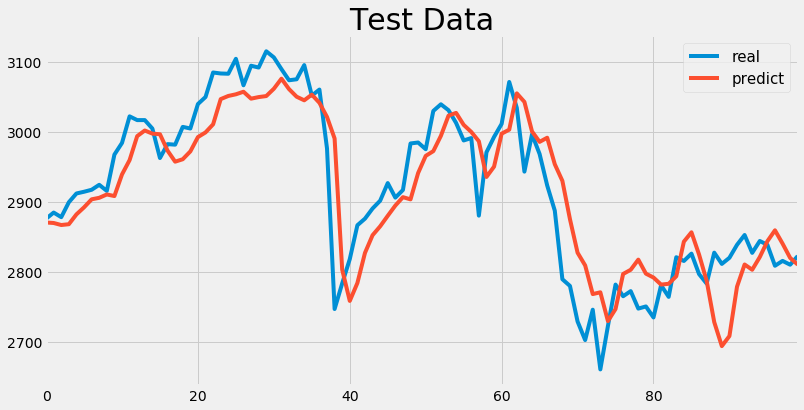

In [311]:
#在测试集上的预测
y_test_predict=model.predict(X_test)

# 反归一化
y_test_predict=np.reshape(y_test_predict, (-1,1))  
y_test_predict= mm_y.inverse_transform(y_test_predict)
y_test=np.reshape(y_test, (-1,1))  
y_test=mm_y.inverse_transform(y_test)

y_test_predict=y_test_predict[:,0]
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[:,0].plot(figsize=(12,6))
draw.iloc[:,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题

In [312]:
#输出结果
y_train=y_train.reshape(-1)
y_train_predict=y_train_predict.reshape(-1)
y_test=y_test.reshape(-1)
y_testpredict=y_test_predict.reshape(-1)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result
def r_square(y_true, y_pred):
    ssr=sum((y_pred-y_true.mean())**2)
    sst=sum((y_true-y_true.mean())**2)
    return ssr/sst
print('训练集上的MAE/RMSE/MAPE/R-square/涨跌准确率')
print(mean_absolute_error(y_train_predict, y_train))
print(np.sqrt(mean_squared_error(y_train_predict, y_train) ))
print(mape(y_train_predict, y_train) )
print(r_square(y_train_predict, y_train) )
print(up_down_accuracy(y_train_predict,y_train))
print('测试集上的MAE/RMSE/MAPE/R-square/涨跌准确率')
print(mean_absolute_error(y_test_predict, y_test))
print(np.sqrt(mean_squared_error(y_test_predict, y_test) ))
print(mape(y_test_predict,  y_test) )
print(r_square(y_test_predict,  y_test) )
print(up_down_accuracy(y_test_predict,y_test))

训练集上的MAE/RMSE/MAPE/R-square/涨跌准确率
39.07769897973311
59.444166882871315
1.2438345617576256
0.9958752468303238
0.5
测试集上的MAE/RMSE/MAPE/R-square/涨跌准确率
41.805192093749994
55.48911167545418
1.4417053496440149
1.2928427904811919
0.5656565656565656
